# Week 5: Simple single-cell RNA-seq analysis

1. fetch some single-cell data and create a cell-gene expression matrix and the associated AnnData object;
2. cluster the data to understand the cell structure; and
3. annotate the data with biologically relevant information.

## Step 0: Setup

Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import celltypist
from celltypist import models
from pathlib import Path
import urllib.request
import subprocess
import gzip
import shutil
import tarfile
import pyroe
import scanpy as sc
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import mygene

Set up directories

In [2]:
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

toy_ref_read = data_dir / "toy_ref_read"
fastq_dir = toy_ref_read / "toy_read_fastq"
ref_dir = toy_ref_read / "toy_human_ref"

r1_fastq = fastq_dir / "selected_R1_reads.fastq"
r2_fastq = fastq_dir / "selected_R2_reads.fastq"
genome_fa = ref_dir / "fasta" / "genome.fa"
genes_gtf = ref_dir / "genes" / "genes.gtf"
whitelist_path = data_dir / "whitelist.txt"

output_dir = data_dir / "alevin_output"
index_dir = output_dir / "salmon_index"
map_dir = output_dir / "map"
quant_dir = output_dir / "quant"

for d in [output_dir, index_dir, map_dir, quant_dir]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Working directory: {Path.cwd()}")
print(f"Data directory: {data_dir}")

Working directory: /mnt/c/Users/Nick/documents/github/fall25-csc-bioinf/week6/code
Data directory: data


## Step 1: Download and Extract Data

In [3]:
toy_dataset_gz = data_dir / "toy_read_ref_set.tar.gz"

if not r1_fastq.exists():
    print("Extracting dataset")
    with tarfile.open(toy_dataset_gz, 'r:gz') as tar:
        tar.extractall(path=data_dir)
    print("Dataset extracted")
else:
    print("Dataset already extracted")

if not whitelist_path.exists():
    print("Downloading whitelist")
    whitelist_url = "https://raw.githubusercontent.com/f0t1h/3M-february-2018/master/3M-february-2018.txt.gz"
    whitelist_gz = data_dir / "3M-february-2018.txt.gz"
    
    urllib.request.urlretrieve(whitelist_url, whitelist_gz)
    with gzip.open(whitelist_gz, 'rb') as f_in:
        with open(whitelist_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    whitelist_gz.unlink()
    print("Whitelist downloaded")
else:
    print("Whitelist already exists")

Dataset already extracted
Whitelist already exists


## Step 2: Alevin-fry alignment and quantification

### Splici transcriptome generation

Read length: 91 bp
Flank trim length: 5 bp

### Salmon indexing

Threads: 4 (balances speed with resource usage)

Index type: k-mer based for fast mapping

### Mapping with salmon alevin

Library type: ISR (inward, stranded, reverse)

Chemistry: Chromium v3 (matches experimental protocol)

Sketch mode: lightweight mapping for speed

### Permit list generation

Direction: fw (forward)

### Collation and quantification

Resolution mode: cr-like (CellRanger-like output)
Output format: mtx

In [4]:
THREADS = "4"

splici_fa = index_dir / "splici_fl86.fa"
if not splici_fa.exists():
    pyroe.make_splici_txome(gtf_path=str(genes_gtf), genome_path=str(genome_fa), read_length=91, output_dir=str(index_dir), flank_trim_length=5, filename_prefix="splici")
    print("Splici transcriptome created")
else:
    print("Splici transcriptome already exists")

salmon_idx_dir = index_dir / "salmon_idx"
if not (salmon_idx_dir / "hash.bin").exists():
    subprocess.run(["salmon", "index", "-t", splici_fa, "-i", salmon_idx_dir, "-p", THREADS], capture_output=True, text=True)
    print("Salmon index created")
else:
    print("Salmon index already exists")

map_rad = map_dir / "map.rad"
if not map_rad.exists():
    subprocess.run(["salmon", "alevin", "-l", "ISR", "-i", salmon_idx_dir, "-1", r1_fastq, "-2", r2_fastq, "-o", map_dir, "-p", THREADS, "--sketch", "--chromiumV3"], capture_output=True, text=True)
    print("Mapping complete")
else:
    print("Mapping already complete")

permit_list = quant_dir / "permit_list.txt"
if not permit_list.exists():
    subprocess.run(["alevin-fry", "generate-permit-list", "-i", map_dir,"-o", quant_dir, "-u", whitelist_path, "-d", "fw"], capture_output=True, text=True)
    print("Permit list generated")
else:
    print("Permit list already exists")

collated_rad = quant_dir / "map.collated.rad"
if not collated_rad.exists():
    subprocess.run(["alevin-fry", "collate", "-r", map_dir, "-i", quant_dir, "-t", THREADS], capture_output=True, text=True)
    print("Collation complete")
else:
    print("Collation already complete")

quant_mtx = quant_dir / "alevin" / "quants_mat.mtx"
t2g_file = index_dir / "splici_fl86_t2g_3col.tsv"
if not quant_mtx.exists():
    subprocess.run(["alevin-fry", "quant", "-i", quant_dir, "-o", quant_dir, "-r", "cr-like", "-m", t2g_file, "-t", THREADS, "--use-mtx"], capture_output=True, text=True)
    print("Quantification complete")
else:
    print("Quantification already complete")

Splici transcriptome already exists
Salmon index created
Mapping already complete
Permit list generated
Collation already complete
Quantification already complete


## Step 3: Cell clustering

Perform cell clustering (via Leiden modularity algorithm). Output the clustering plot.

### QC filtering

Min genes per cell: 5 (removes empty droplets/debris)
Min cells per gene: 2 (removes noise/spurious genes)
High gene count threshold: 95th percentile (removes doublets)
Mitochondrial content: <20% (removes dying/stressed cells)

### Normalization

Target sum: 10,000 counts per cell
Log transformation: log1p (stabilizes variance)


### Feature selection

Highly variable genes: Top 30 genes

Min mean: 0.0125 Max mean: 3 Min dispersion: 0.5

### Dimensionality reduction

Scaling max value: 10 (prevents extreme outliers dominating)
PCA components: 20 (or fewer if limited by data size)
Neighbor graph: 10 neighbors (standard for cell clustering)
PCs for neighbors: 10 (balances noise vs signal)

### UMAP and Clustering

UMAP: Default parameters
Leiden resolution: 0.3 (lower = fewer, larger clusters)


Load data

In [5]:
print("Loading data from alevin-fry output")

mtx_file = quant_dir / 'alevin' / 'quants_mat.mtx'
barcodes_file = quant_dir / 'alevin' / 'quants_mat_rows.txt'
features_file = quant_dir / 'alevin' / 'quants_mat_cols.txt'

mtx = sio.mmread(mtx_file)
barcodes = pd.read_csv(barcodes_file, header=None, names=['barcode'])
features = pd.read_csv(features_file, header=None, names=['gene_id'])

X = mtx.tocsr()

adata = sc.AnnData(X=X, obs=pd.DataFrame(index=barcodes['barcode'].values), var=pd.DataFrame(index=features['gene_id'].values))

print(f"Loaded data: {adata.n_obs} cells × {adata.n_vars} genes")

Loading data from alevin-fry output
Loaded data: 139 cells × 60 genes


QC Filtering

In [6]:
sc.pp.filter_cells(adata, min_genes=5)
sc.pp.filter_genes(adata, min_cells=2)

adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata = adata[adata.obs.n_genes_by_counts < adata.obs.n_genes_by_counts.quantile(0.95), :]
adata = adata[adata.obs.pct_counts_mt < 20, :] 

print(f"After QC filtering: {adata.n_obs} cells × {adata.n_vars} genes")


Performing QC filtering
After filtering: 123 cells × 56 genes


Clustering plot saved to data/clustering_plot.png


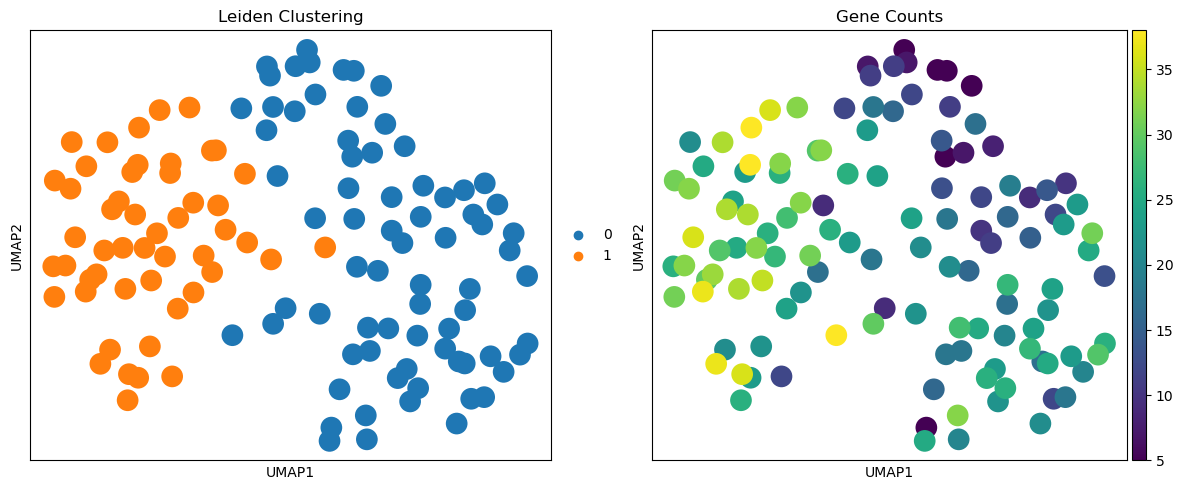

Processed data saved to data/adata_clustered.h5ad


In [7]:
warnings.filterwarnings('ignore')
# normalizing data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# checking for variable genes
if adata.n_vars > 20 and adata.n_obs > 20:
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=min(30, adata.n_vars))
    adata.raw = adata
    if adata.var.highly_variable.sum() > 10:
        adata = adata[:, adata.var.highly_variable]
else:
    adata.raw = adata

# scaling and computing PCA
sc.pp.scale(adata, max_value=10)
n_pcs = min(20, adata.n_vars - 1, adata.n_obs - 1)
sc.tl.pca(adata, svd_solver='arpack', n_comps=n_pcs)

# computing neighborhood graph
n_neighbors = min(10, adata.n_obs // 2)
n_pcs_use = min(10, n_pcs)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs_use)

# computing UMAP
sc.tl.umap(adata)

# performing Leiden clustering")
sc.tl.leiden(adata, resolution=0.3)

# generating clustering plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sc.pl.umap(adata, color='leiden', ax=axes[0], show=False, title='Leiden Clustering')
sc.pl.umap(adata, color='n_genes_by_counts', ax=axes[1], show=False, title='Gene Counts')

plt.tight_layout()
plt.savefig(data_dir / 'clustering_plot.png', dpi=300, bbox_inches='tight')
print(f"Clustering plot saved to {data_dir / 'clustering_plot.png'}")
plt.show()


adata.write(data_dir / 'adata_clustered.h5ad')
print(f"Processed data saved to {data_dir / 'adata_clustered.h5ad'}")

## Step 4: Cell annotation

Perform automatic cell annotation via CellTypist. Annotate the plot with the cell types.

### Gene ID Conversion (CellTypist requires gene symbols)

Source: Ensembl IDs to Gene symbols
Tool: MyGeneInfo API

In [8]:
# Load data
adata = sc.read_h5ad(data_dir / 'adata_clustered.h5ad')
adata_for_annotation = adata.raw.to_adata() if adata.raw is not None else adata.copy()

# Convert Ensembl IDs to gene symbols
mg = mygene.MyGeneInfo()
ensembl_ids = [gid.split('-')[0] for gid in adata_for_annotation.var_names]  # Clean IDs
results = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')

# Map to symbols
id_to_symbol = {r['query']: r.get('symbol', r['query']) for r in results}
new_gene_names = [id_to_symbol.get(gid.split('-')[0], gid) for gid in adata_for_annotation.var_names]

# Update gene names
adata_for_annotation.var_names = new_gene_names
adata_for_annotation.var_names_make_unique()

# Update main adata
if adata.raw is not None:
    adata.raw._var.index = new_gene_names
else:
    adata.var_names = new_gene_names
    adata.var_names_make_unique()

# Save
adata.write(data_dir / 'adata_clustered_with_symbols.h5ad')

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
querying 1-56 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
Finished.
19 input query terms found dup hits:	[('ENSG00000131507', 3), ('ENSG00000131508', 3), ('ENSG00000134982', 3), ('ENSG00000038427', 3), ('E
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


### CellTypist

### Model: Immune_All_Low.pkl

- Pan-immune cell reference
- Low resolution (broad cell types)


### Majority voting: Enabled

- Smooths predictions using neighborhood graph
- Reduces noise in assignments


### Resolution: 5 (for over-clustering before voting) Higher = more granular before consensus

🔬 Input data has 123 cells and 56 genes
🔗 Matching reference genes in the model
🧬 10 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Cell Type Summary:
Epithelial cells              114
Double-positive thymocytes      5
Tcm/Naive helper T cells        4
Name: celltypist_cell_type, dtype: int64

Confidence Scores - Mean: 0.004, Min: 0.001, Max: 0.011


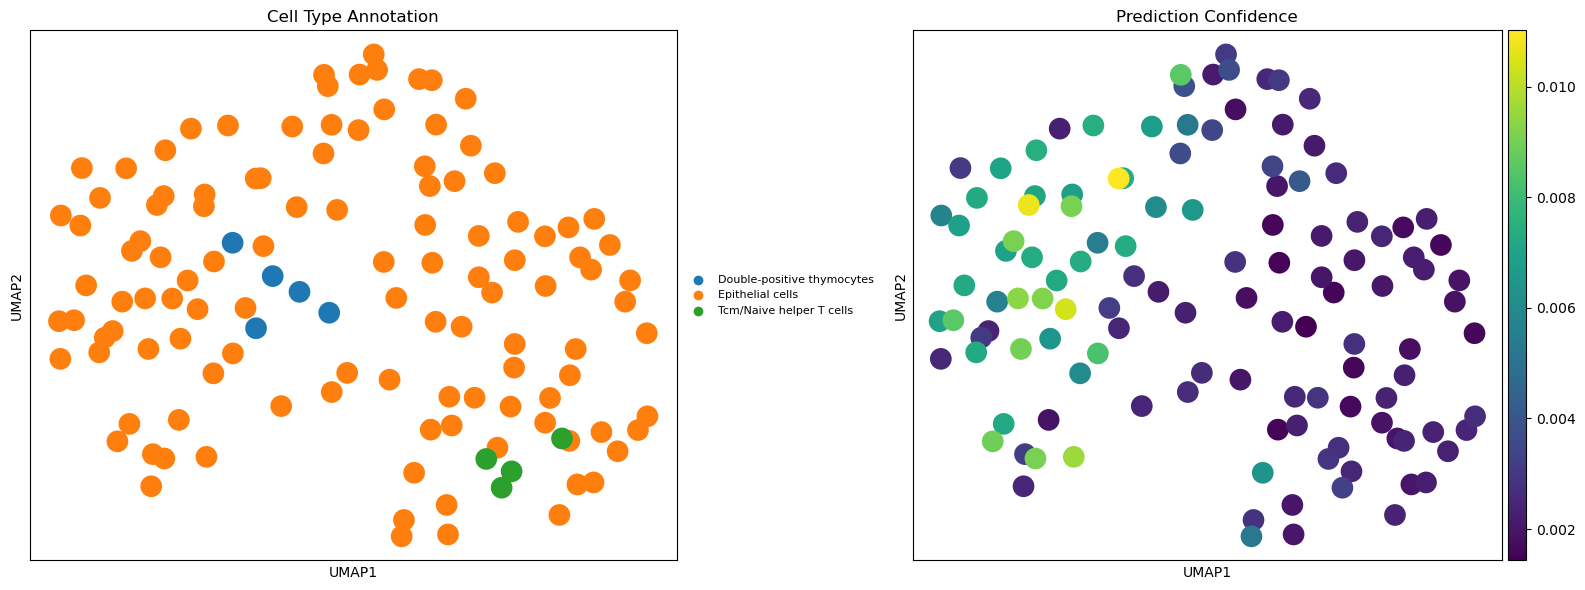

Saved to data/adata_annotated_final.h5ad


In [9]:
warnings.filterwarnings('ignore')

# load data
adata = sc.read_h5ad(data_dir / 'adata_clustered_with_symbols.h5ad')

# use raw data for annotation
adata_for_annotation = adata.raw.to_adata() if adata.raw is not None else adata.copy()

# load model and predict
model = models.Model.load(model='Immune_All_Low.pkl')
predictions = celltypist.annotate(adata_for_annotation, model=model, majority_voting=True)

# extract annotations
adata.obs['celltypist_cell_type'] = predictions.predicted_labels['majority_voting'].values
adata.obs['celltypist_conf_score'] = predictions.probability_matrix.max(axis=1)

# summary
print(f"Cell Type Summary:\n{adata.obs['celltypist_cell_type'].value_counts()}\n")
print(f"Confidence Scores - Mean: {adata.obs['celltypist_conf_score'].mean():.3f}, "
      f"Min: {adata.obs['celltypist_conf_score'].min():.3f}, "
      f"Max: {adata.obs['celltypist_conf_score'].max():.3f}")

# plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sc.pl.umap(adata, color='celltypist_cell_type', ax=axes[0], show=False, 
           title='Cell Type Annotation', legend_fontsize=8, legend_loc='right margin')
sc.pl.umap(adata, color='celltypist_conf_score', ax=axes[1], show=False,
           title='Prediction Confidence', cmap='viridis')
plt.tight_layout()
plt.show()

# save
adata.write(data_dir / 'adata_annotated_final.h5ad')
print(f"Saved to {data_dir / 'adata_annotated_final.h5ad'}")

## Time Estimate: 8 Hours